In [15]:
import pandas as pd
import numpy as np
import pickle
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [9]:
df = pd.read_csv("IMDB_cleaned.csv")
print("Loaded cleaned df:", df.shape)
display(df.head())

y = df['sentiment'].map({'positive': 1, 'negative': 0})  # numeric labels
X_text = df['clean_review']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)
print("Train text:", len(X_train_text), "Test text:", len(X_test_text))

with open("X_train_bow.pkl", "rb") as f: X_train_bow = pickle.load(f)
with open("X_test_bow.pkl", "rb") as f: X_test_bow = pickle.load(f)
with open("X_train_tfidf.pkl", "rb") as f: X_train_tfidf = pickle.load(f)
with open("X_test_tfidf.pkl", "rb") as f: X_test_tfidf = pickle.load(f)

print("BoW shape (train/test):", X_train_bow.shape, X_test_bow.shape)
print("TF-IDF shape (train/test):", X_train_tfidf.shape, X_test_tfidf.shape)

w2v_model = Word2Vec.load("imdb_word2vec.model")
print("Word2Vec vocab size:", len(w2v_model.wv))

Loaded cleaned df: (49500, 4)


,review,sentiment,review_length,clean_review
0,One of the other reviewers has mentioned that ...,positive,307,one reviewer mentioned watching oz episode hoo...
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,138,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter mattei love time money visually stunnin...


Train text: 39600 Test text: 9900
BoW shape (train/test): (39600, 10000) (9900, 10000)
TF-IDF shape (train/test): (39600, 10000) (9900, 10000)
Word2Vec vocab size: 22835


In [12]:
# average Word2Vec vectors per review

def vectorize_reviews_w2v(texts, model):
    """texts: iterable of cleaned-review strings (already tokenized by spaces)
       model: gensim Word2Vec model
       returns: numpy array (n_samples, vector_size)
    """
    vec_size = model.vector_size
    arr = np.zeros((len(texts), vec_size), dtype=np.float32)
    for i, doc in enumerate(texts):
        tokens = doc.split()
        valid = [t for t in tokens if t in model.wv]
        if len(valid) > 0:
            arr[i] = np.mean(model.wv[valid], axis=0)
        else:
            # fallback: small random vector or zeros (we use zeros)
            arr[i] = np.zeros(vec_size, dtype=np.float32)
    return arr

X_train_w2v = vectorize_reviews_w2v(X_train_text.values, w2v_model)
X_test_w2v  = vectorize_reviews_w2v(X_test_text.values, w2v_model)

print("W2V shapes:", X_train_w2v.shape, X_test_w2v.shape)

with open("X_train_w2v.pkl", "wb") as f: pickle.dump(X_train_w2v, f)
with open("X_test_w2v.pkl", "wb") as f: pickle.dump(X_test_w2v, f)
print("Saved X_train_w2v.pkl and X_test_w2v.pkl")

W2V shapes: (39600, 200) (9900, 200)
Saved X_train_w2v.pkl and X_test_w2v.pkl


In [14]:
# train/evaluate helper

def train_and_evaluate(name, model, X_tr, X_te, y_tr, y_te, show_confusion=True):
    """
    Trains model, prints main metrics and shows confusion matrix if requested.
    name: string label
    model: sklearn-like estimator (must have fit & predict)
    X_tr, X_te: features (sparse or dense)
    y_tr, y_te: labels (1/0)
    Returns: dict with metrics
    """
    print(f"\n=== {name} ===")
    t0 = time.time()
    model.fit(X_tr, y_tr)
    train_time = time.time() - t0

    # If X_te is sparse and the model can't handle it we'll let it fail,
    # but most sklearn linear models and NB handle sparse fine.
    y_pred = model.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, zero_division=0)
    rec = recall_score(y_te, y_pred, zero_division=0)
    f1 = f1_score(y_te, y_pred, zero_division=0)

    print(f"Time: {train_time:.2f}s  Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print("\nClassification report:\n", classification_report(y_te, y_pred, digits=4, zero_division=0))

    if show_confusion:
        cm = confusion_matrix(y_te, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix: {name}")
        plt.show()

    return {"name": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "time_s": train_time}


### Train LogisticRegression, MultinomialNB, LinearSVC on BoW and TF-IDF


=== LogReg on BoW ===
Time: 14.92s  Accuracy: 0.8759  Precision: 0.8722  Recall: 0.8818  F1: 0.8770

Classification report:
               precision    recall  f1-score   support

           0     0.8797    0.8699    0.8747      4933
           1     0.8722    0.8818    0.8770      4967

    accuracy                         0.8759      9900
   macro avg     0.8759    0.8758    0.8758      9900
weighted avg     0.8759    0.8759    0.8759      9900



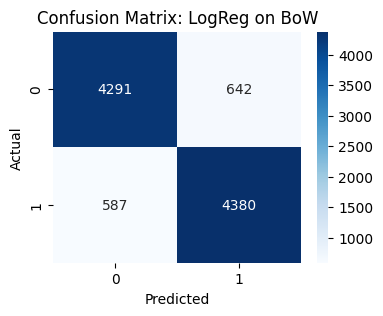


=== MultinomialNB on BoW ===
Time: 0.03s  Accuracy: 0.8634  Precision: 0.8567  Recall: 0.8740  F1: 0.8653

Classification report:
               precision    recall  f1-score   support

           0     0.8705    0.8528    0.8616      4933
           1     0.8567    0.8740    0.8653      4967

    accuracy                         0.8634      9900
   macro avg     0.8636    0.8634    0.8634      9900
weighted avg     0.8636    0.8634    0.8634      9900



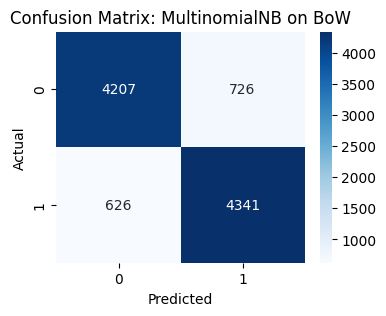


=== LinearSVC on BoW ===
Time: 91.20s  Accuracy: 0.8486  Precision: 0.8465  Recall: 0.8528  F1: 0.8497

Classification report:
               precision    recall  f1-score   support

           0     0.8507    0.8443    0.8475      4933
           1     0.8465    0.8528    0.8497      4967

    accuracy                         0.8486      9900
   macro avg     0.8486    0.8486    0.8486      9900
weighted avg     0.8486    0.8486    0.8486      9900



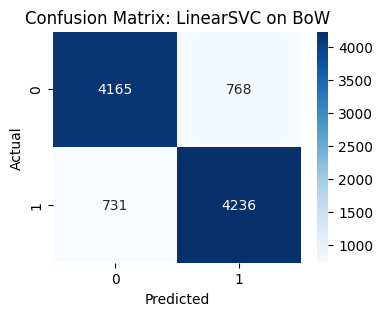


=== LogReg on TF-IDF ===
Time: 1.48s  Accuracy: 0.8984  Precision: 0.8876  Recall: 0.9130  F1: 0.9002

Classification report:
               precision    recall  f1-score   support

           0     0.9098    0.8836    0.8965      4933
           1     0.8876    0.9130    0.9002      4967

    accuracy                         0.8984      9900
   macro avg     0.8987    0.8983    0.8984      9900
weighted avg     0.8987    0.8984    0.8984      9900



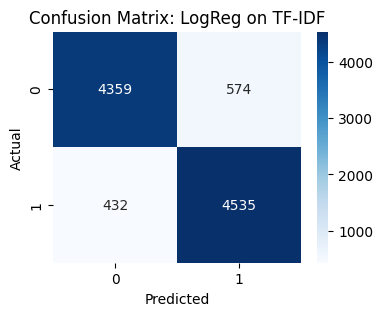


=== MultinomialNB on TF-IDF ===
Time: 0.05s  Accuracy: 0.8722  Precision: 0.8596  Recall: 0.8909  F1: 0.8749

Classification report:
               precision    recall  f1-score   support

           0     0.8859    0.8534    0.8694      4933
           1     0.8596    0.8909    0.8749      4967

    accuracy                         0.8722      9900
   macro avg     0.8727    0.8722    0.8722      9900
weighted avg     0.8727    0.8722    0.8722      9900



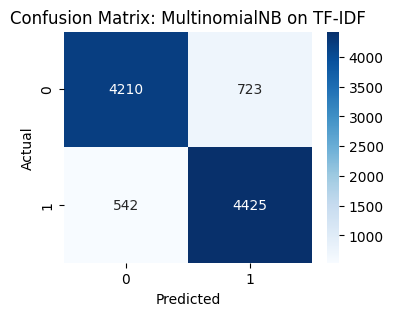


=== LinearSVC on TF-IDF ===
Time: 1.73s  Accuracy: 0.8919  Precision: 0.8875  Recall: 0.8985  F1: 0.8930

Classification report:
               precision    recall  f1-score   support

           0     0.8965    0.8853    0.8909      4933
           1     0.8875    0.8985    0.8930      4967

    accuracy                         0.8919      9900
   macro avg     0.8920    0.8919    0.8919      9900
weighted avg     0.8920    0.8919    0.8919      9900



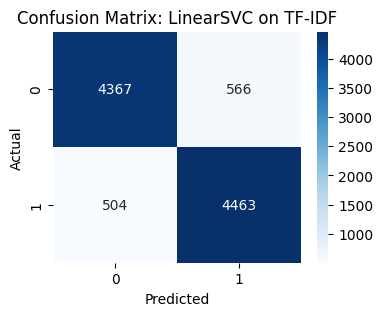

In [16]:
results = []

models_sparse = [
    ("LogReg", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)),
    ("MultinomialNB", MultinomialNB()),
    ("LinearSVC", LinearSVC(max_iter=5000, random_state=42))
]

for name, model in models_sparse:
    res = train_and_evaluate(f"{name} on BoW", model, X_train_bow, X_test_bow, y_train, y_test)
    results.append(res)

for name, model in models_sparse:
    res = train_and_evaluate(f"{name} on TF-IDF", model, X_train_tfidf, X_test_tfidf, y_train, y_test)
    results.append(res)

### Train models on Word2Vec averaged vectors


=== LogReg on Word2Vec ===
Time: 3.32s  Accuracy: 0.8851  Precision: 0.8827  Recall: 0.8891  F1: 0.8859

Classification report:
               precision    recall  f1-score   support

           0     0.8875    0.8810    0.8842      4933
           1     0.8827    0.8891    0.8859      4967

    accuracy                         0.8851      9900
   macro avg     0.8851    0.8850    0.8850      9900
weighted avg     0.8851    0.8851    0.8850      9900



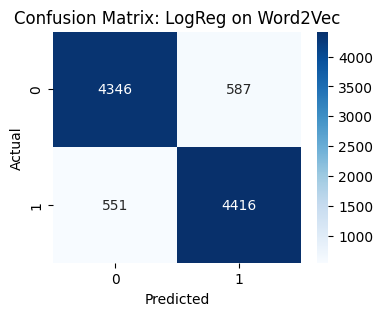


=== LinearSVC on Word2Vec ===
Time: 3.06s  Accuracy: 0.8875  Precision: 0.8851  Recall: 0.8915  F1: 0.8883

Classification report:
               precision    recall  f1-score   support

           0     0.8899    0.8834    0.8867      4933
           1     0.8851    0.8915    0.8883      4967

    accuracy                         0.8875      9900
   macro avg     0.8875    0.8875    0.8875      9900
weighted avg     0.8875    0.8875    0.8875      9900



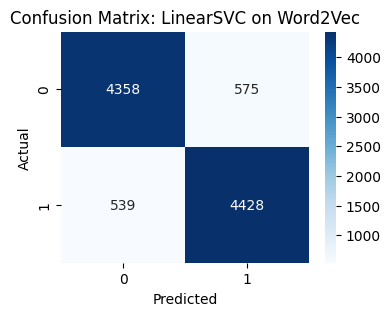

In [17]:
results_w2v = []

models_dense = [
    ("LogReg", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)),
    ("LinearSVC", LinearSVC(max_iter=5000, random_state=42))
]

for name, model in models_dense:
    res = train_and_evaluate(f"{name} on Word2Vec", model, X_train_w2v, X_test_w2v, y_train, y_test)
    results.append(res)
    results_w2v.append(res)


### Summary table of results

In [18]:
results_df = pd.DataFrame(results)
results_df = results_df[["name", "accuracy", "precision", "recall", "f1", "time_s"]]
display(results_df.sort_values("f1", ascending=False).reset_index(drop=True))

,name,accuracy,precision,recall,f1,time_s
0,LogReg on TF-IDF,0.898384,0.887649,0.913026,0.900159,1.484761
1,LinearSVC on TF-IDF,0.891919,0.887453,0.898530,0.892957,1.733484
2,LinearSVC on Word2Vec,0.887475,0.885069,0.891484,0.888265,3.061613
3,LogReg on Word2Vec,0.885051,0.882670,0.889068,0.885858,3.322372
4,LogReg on BoW,0.875859,0.872162,0.881820,0.876965,14.924187
5,MultinomialNB on TF-IDF,0.872222,0.859557,0.890880,0.874938,0.052279
6,MultinomialNB on BoW,0.863434,0.856720,0.873968,0.865258,0.029730
7,LinearSVC on BoW,0.848586,0.846523,0.852829,0.849664,91.196205


In [20]:
# Save results
results_df.to_csv("phaseC_results_summary.csv", index=False)
print("Saved phaseC_results_summary.csv")

Saved phaseC_results_summary.csv


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'C': 1} Best CV f1: 0.8980767256998963

=== Tuned LogReg on TF-IDF ===
Time: 1.74s  Accuracy: 0.8984  Precision: 0.8876  Recall: 0.9130  F1: 0.9002

Classification report:
               precision    recall  f1-score   support

           0     0.9098    0.8836    0.8965      4933
           1     0.8876    0.9130    0.9002      4967

    accuracy                         0.8984      9900
   macro avg     0.8987    0.8983    0.8984      9900
weighted avg     0.8987    0.8984    0.8984      9900



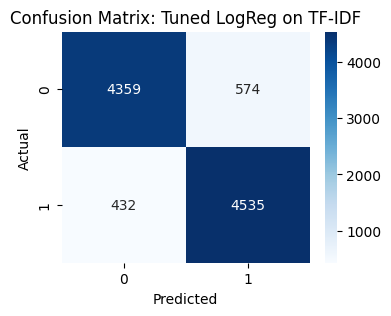

{'name': 'Tuned LogReg on TF-IDF',
 'accuracy': 0.8983838383838384,
 'precision': 0.8876492464278724,
 'recall': 0.9130259714113147,
 'f1': 0.9001587931718936,
 'time_s': 1.7383313179016113}

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [0.01, 0.1, 1, 5, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000, solver="liblinear", random_state=42),
                    param_grid, scoring="f1", cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train_tfidf, y_train)
print("Best params:", grid.best_params_, "Best CV f1:", grid.best_score_)
best_lr = grid.best_estimator_
# Evaluate best on test
train_and_evaluate("Tuned LogReg on TF-IDF", best_lr, X_train_tfidf, X_test_tfidf, y_train, y_test)
